# FOOOF Algorithm

<div class="alert alert-success">
This notebook takes a step by step approach, with the code, on how the FOOOF fitting algorithm works.             <br>Note that this notebook is for demonstrative purposes, and does not represent recommended usage of the fooof module.
</div>

<div class="alert alert-info">
To get an introduction to the codebase, go back [here](02-FOOOF.ipynb), or to skip ahead to more code examples, go ahead to [here](04-FOOOFGroup.ipynb).
</div>

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from fooof import FOOOF

# Import some internal functions from FOOOF
from fooof.synth import gen_background
from fooof.core.funcs import gaussian_function
from fooof.plts.templates import plot_spectrum
from fooof.plts.fm import plot_peak_iter

In [2]:
# Set whether to plot in log-log space (used across the whole notebook)
plt_log = False

In [3]:
# Load example data
freqs = np.load('dat/freqs_2.npy')
spectrum = np.load('dat/spectrum_2.npy')

In [4]:
# Initialize FOOOF object
fm = FOOOF(peak_width_limits=[1, 8], max_n_peaks=6 , min_peak_amplitude=0.15)

Note that data can be added to FOOF independent of fitting the model. You can then plot input data.

In [5]:
# Add data to FOOOF object
fm.add_data(freqs, spectrum, [3, 40])

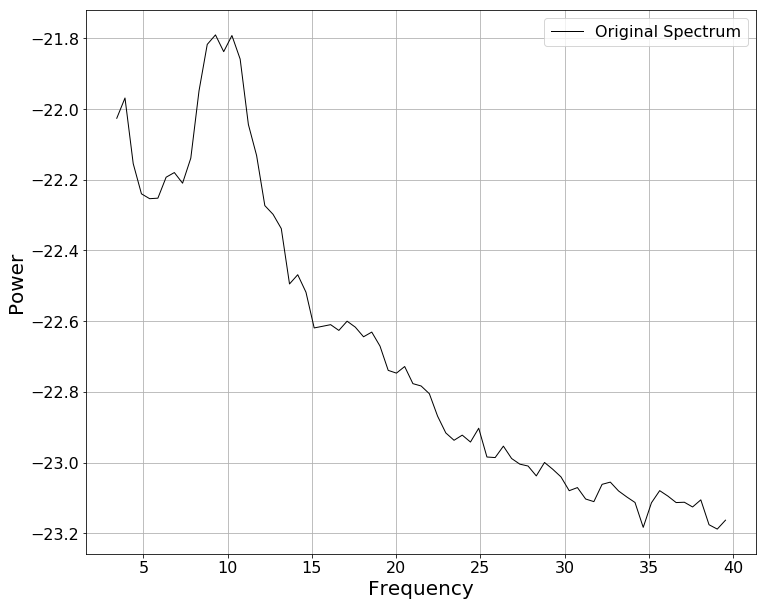

In [6]:
# Plot the power spectrum that we just added
fm.plot(plt_log)

The FOOOF object stores most of the intermediate steps internally. 

For this notebook, we will first fit the full model, as normal, but then step through, and visualize each step the algorithm takes to come to the final fit. 

In [7]:
# Fit the FOOOF model.
fm.fit(freqs, spectrum, [3, 40])

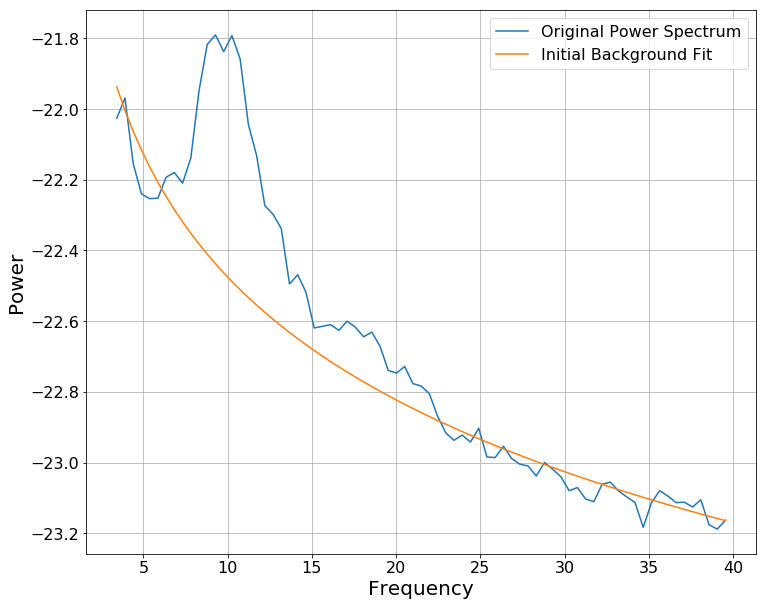

In [8]:
# Initial background fit - do a robust background fit (excluding outliers)
#  This recreates an initial fit that isn't ultimately stored in the FOOOF object)
init_bg_fit = gen_background(fm.freqs, fm._robust_bg_fit(fm.freqs, fm.power_spectrum))

# Plot the initial background fit
_, ax = plt.subplots(figsize=(12, 10))
plot_spectrum(fm.freqs, fm.power_spectrum, plt_log, label='Original Power Spectrum', ax=ax)
plot_spectrum(fm.freqs, init_bg_fit, plt_log, label='Initial Background Fit', ax=ax)

The initial fit, as above, is used to create a flattened spectrum, from which peaks can be extracted.

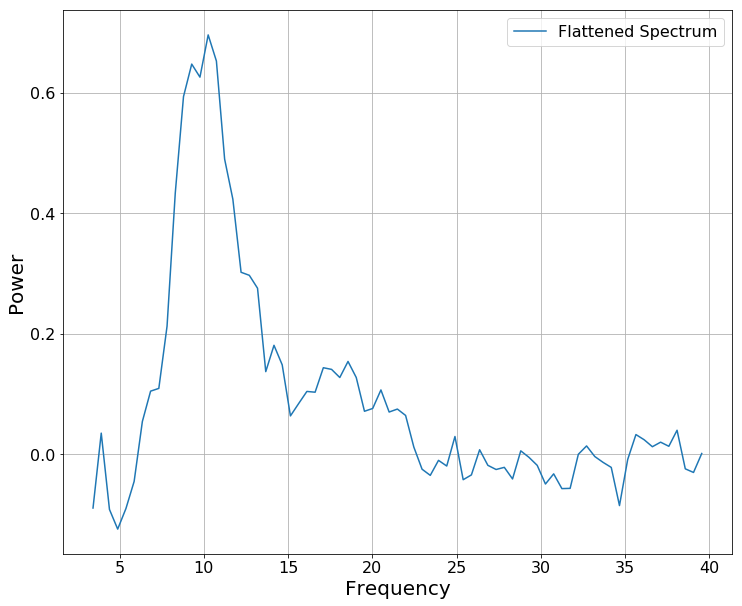

In [9]:
# Flatten the power spectrum, by subtracting out the initial background fit
plot_spectrum(fm.freqs, fm._spectrum_flat, plt_log, label='Flattened Spectrum')

With the flattened spectrum, FOOOF then initiates an iterative procedure to find peaks. 

For each iteration:
- The maximum point of the flattened spectrum is found. If this point fails to pass the relative or absolute amplitude threshold, the procedure halts.
- A gaussian is fit around the maximum point
- The guess gaussian is subtracted out from the flatted spectrum
- The procedure continues to a new iteration with the new version of the flattend spectrum, unless _max_n_peaks_ has been reached. 

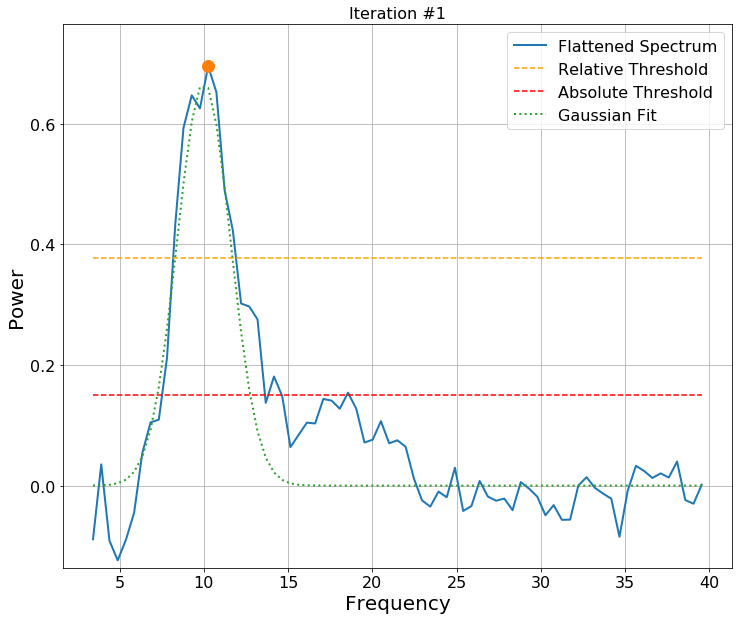

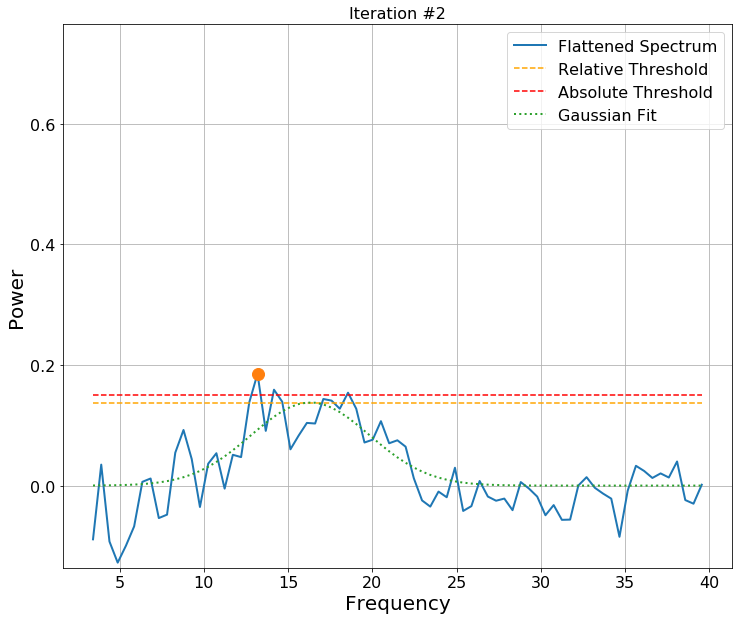

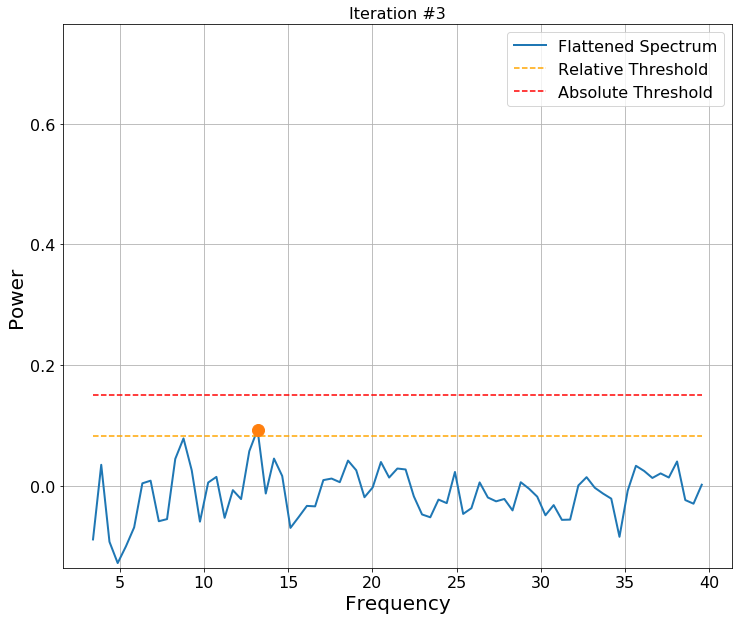

In [10]:
# Plot the iterative approach to finding peaks from the flattened spectrum
plot_peak_iter(fm)

Once the iterative procedure has halted, the extracted 'guess' peaks, are then re-fit, all together, to the flattened spectrum, creating a peak fit. 

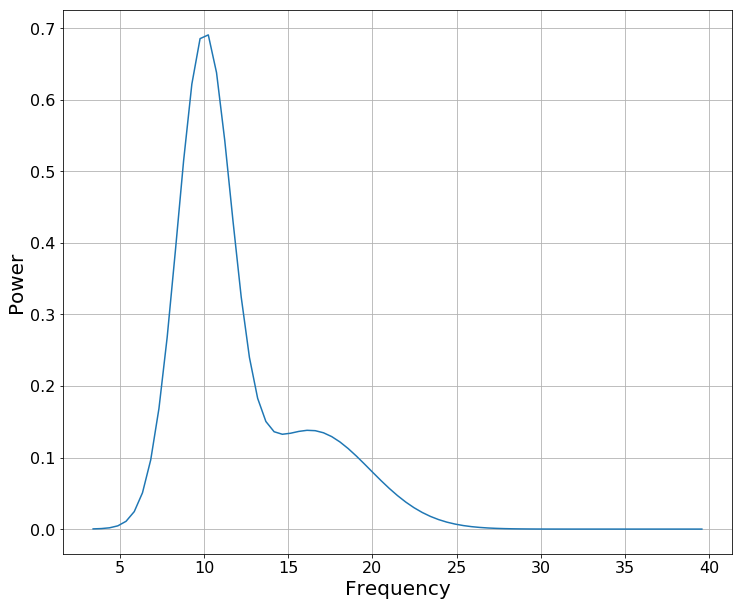

In [11]:
# Fit gaussians to all candidate peaks together, and create peak fit
plot_spectrum(fm.freqs, fm._peak_fit, plt_log)

This is now the peak component of the fit completed. This fit is then used to go back and try and get a better background fit. 

To do so, the peak fit is removed from the original power spectrum, leaving a 'background-only' spectrum for re-fitting. 

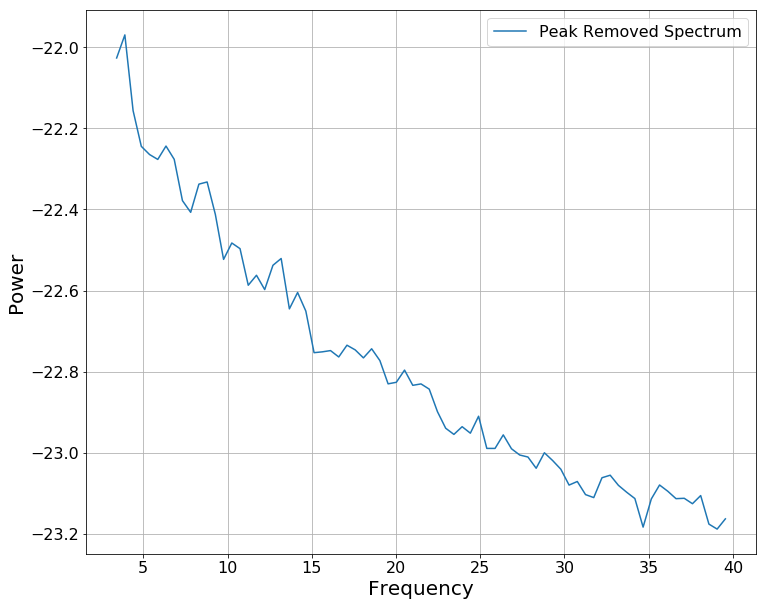

In [12]:
# Create peak removed power spectrum (by removing peak fit from original spectrum)
plot_spectrum(fm.freqs, fm._spectrum_peak_rm, plt_log, label='Peak Removed Spectrum')

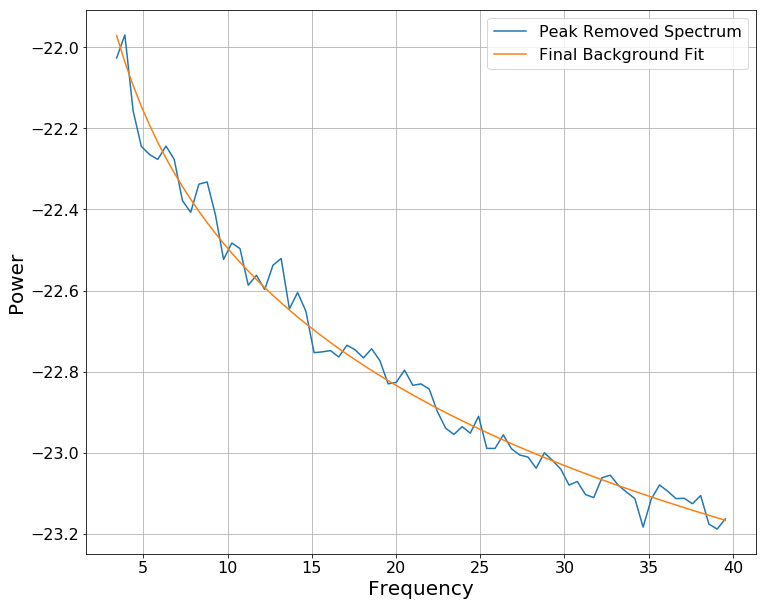

In [13]:
# Fit the final background fit on the peak removed power spectrum
_, ax = plt.subplots(figsize=(12, 10))
plot_spectrum(fm.freqs, fm._spectrum_peak_rm, plt_log, label='Peak Removed Spectrum', ax=ax)
plot_spectrum(fm.freqs, fm._bg_fit, plt_log, label='Final Background Fit', ax=ax)

The background fit component of the model is now also complete. The two components can now be combined. 

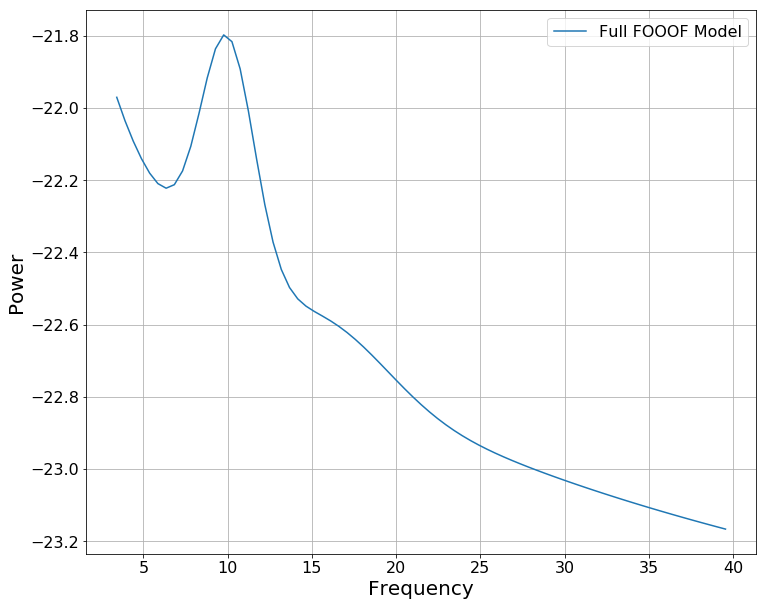

In [14]:
# Recreate the full FOOOF model, by combining the peak & background fits
plot_spectrum(fm.freqs, fm.fooofed_spectrum_, plt_log, label='Full FOOOF Model')

In [15]:
# The last stage is to calculate the fit error, R^2, and update gaussian parameters -> peak parameters
#  These results are part of what are stored, and printed, as the model results
fm.print_results()

                     FOOOF - POWER SPECTRUM MODEL                     
          The model was run on the frequency range 3 - 40 Hz          
                   Frequency Resolution is 0.49 Hz                    
               Background Parameters (offset, slope):                 
                           -21.3713, 1.1239                           
                         2 peaks were found:                          
                  CF:  10.00, Amp:  0.685, BW:  3.18                  
                  CF:  16.32, Amp:  0.138, BW:  7.03                  
                       Goodness of fit metrics:                       
                      R^2 of model fit is 0.9909                      
                  Root mean squared error is 0.0332                   


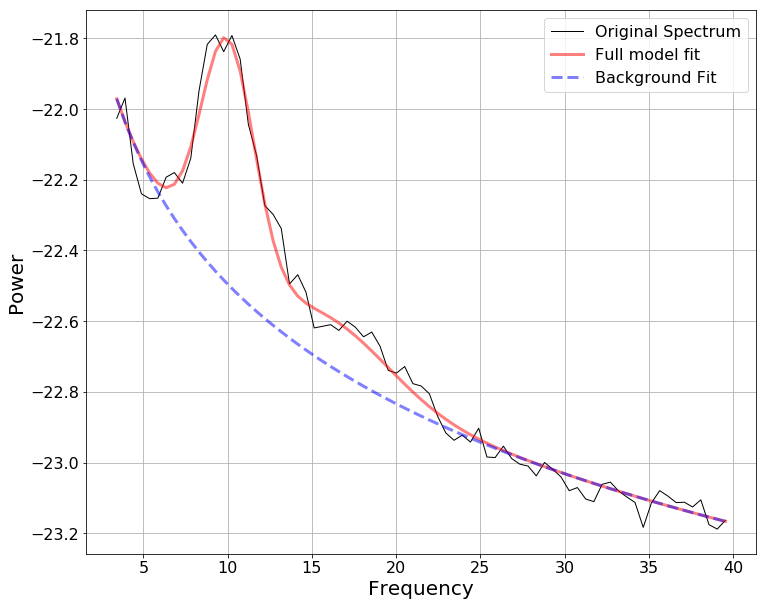

In [16]:
# Plot the full FOOOF model fit of the power spectrum
#  The final fit (red), and background fit (blue), are the same as we plotted above
fm.plot(plt_log)

<div class="alert alert-info">
To continue with the tutorial, exploring the FOOOFGroup object, go [here](04-FOOOFGroup.ipynb).
</div>